## Import image, downsample

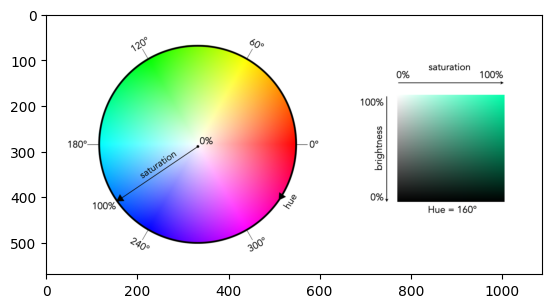

In [1]:
import cv2, numpy as np, torch
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
img_rgb = cv2.cvtColor(cv2.imread(r'data_processing/media/hsb_colourspace3-1.png', 1), cv2.COLOR_BGR2RGB)

step = 1
img_rgb_sub = img_rgb[::step,::step]
H,W,C = img_rgb_sub.shape
plt.imshow(img_rgb_sub)

## Generate random starting color palette

torch.Size([5, 3])
tensor([[ 54, 203, 201],
        [107,  90, 183],
        [148,  49,  22],
        [  9, 184, 225],
        [ 38,  96,  88]])


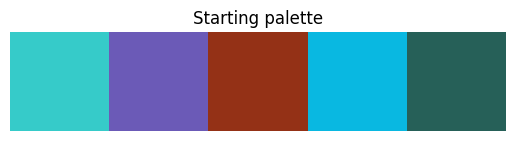

In [9]:

num_colors = 5
img_rgb_sub_flat = img_rgb_sub.reshape(-1,3)
torch.manual_seed(69)
clrs = torch.randint(0,256,size=(num_colors,C))
print(clrs.shape); print(clrs)

palette_start = torch.zeros(size = (5, 5*num_colors, C), dtype= torch.uint8)
for i,c in enumerate(clrs):
    palette_start[:,i*5:(i+1)*5] += c.to(torch.uint8)

plt.imshow(palette_start)
plt.title('Starting palette')
plt.axis('off');

## Evolve palette
1. find which colors are close to current palette
2. isolate pixels for each palette (via mask)
3. calculate average color of masked region
4. replace (update) palette color with averaged
5. repeat

In [3]:
imc     = torch.tensor(img_rgb_sub_flat).unsqueeze(1)

num_iters = 3
img_hist        = torch.zeros(size=(num_iters+1, H*W, C), dtype=torch.float)
bands_storage       = torch.zeros(size=(num_iters+1, num_colors, C))
bands_storage[0]    = clrs

# num_colors 5x5 colored squares for each iteration
pallete_storage = torch.zeros(size = (num_iters, 5, 5*num_colors, C), dtype= torch.uint8)

for k in range(num_iters):
    tr = False

    dists       = torch.norm(imc - bands_storage[[k]], dim=-1)
    masks_IDs   = torch.argmin(dists, dim=-1)
    # iterate through colors
    for i in range(num_colors):
        # find mask
        mask = masks_IDs == i
        # apply specific color to a masked region
        img_hist[k,mask] += bands_storage[k,[i]]
        # add this color to palette
        pallete_storage[k,:,i*5:(i+1)*5] += bands_storage[k,i].to(torch.uint8)

        if sum(mask) > 0:   # if there are pixels that are close to this color
            avg_color = torch.mean(imc[mask], dim = 0, dtype = torch.float)
        else:               # never triggered. replace useless color with random
            avg_color = torch.randint(0,256,size=bands_storage[k,[i]].size)
            tr = True
        bands_storage[k+1,[i]]  += avg_color

    if tr: print('rnd clr')
img_hist = img_hist.reshape(num_iters+1, H, W, C)

## Plot

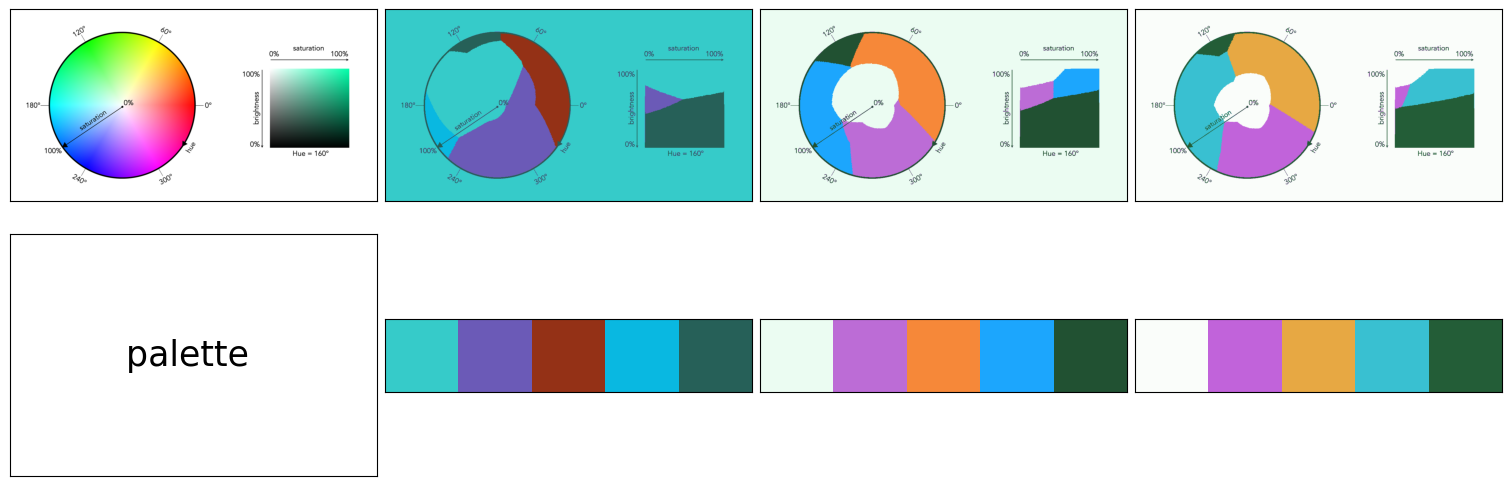

In [4]:
fig, ax = plt.subplots(2,num_iters+1, figsize=(5*num_iters, 5), layout='constrained')
ax[0,0].imshow(img_rgb_sub)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[1,0].text(0.5, 0.5, 'palette ', ha="center", size=25, va='center', transform=ax[1,0].transAxes)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
for i,(img, palette) in enumerate(zip(img_hist, pallete_storage)):
    
    ax[0,i+1].imshow(img.to(torch.uint8))
    ax[1,i+1].imshow(palette)
    ax[0,i+1].set_xticks([])
    ax[0,i+1].set_yticks([])
    ax[1,i+1].set_xticks([])
    ax[1,i+1].set_yticks([])